In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt

# Load MNIST data

In [2]:
train_data = pd.read_csv('/content/drive/MyDrive/MNIST_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/MNIST_test.csv')

In [3]:
test_data

,Unnamed: 0,index,labels,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,0,0,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,4,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,9995,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,9996,9996,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,9997,9997,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,9998,9998,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Transformations

In [4]:
X_train = train_data.drop('labels', axis=1).to_numpy()
y_train = train_data['labels'].to_numpy()
X_test = test_data.drop('labels', axis=1).to_numpy()
y_test = test_data['labels'].to_numpy()

In [5]:
X_train = train_data.iloc[:, 3:].to_numpy() / 255.0
X_test = test_data.iloc[:, 3:].to_numpy() / 255.0

In [6]:
X_train.shape

(60000, 784)

In [7]:
def check_duplicates(X):

    unique_rows = np.unique(X, axis=0)
    if unique_rows.shape[0] == X.shape[0]:
        print("No duplicate rows found")
    else:
        print(f"Found {X.shape[0] - unique_rows.shape[0]} duplicate rows")

# Check  NaN/Null values
def check_nan(X, y=None):
    if np.isnan(X).any():
        print("Null values found in the feature matrix")
    else:
        print("No Null values found in the feature matrix")

    if y is not None and np.isnan(y).any():
        print("Null values found in the labels")
    else:
        print("No Null values found in the labels")


check_duplicates(X_train)
check_nan(X_train, y_train)
check_duplicates(X_test)
check_nan(X_test, y_test)

No duplicate rows found
No Null values found in the feature matrix
No Null values found in the labels
No duplicate rows found
No Null values found in the feature matrix
No Null values found in the labels


In [ ]:
# X_train_min = X_train.min(axis=0)
# X_train_max = X_train.max(axis=0)
# X_train_scaled = (X_train - X_train_min) / (X_train_max - X_train_min + 1e-8)
# X_test_scaled = (X_test - X_train_min) / (X_train_max - X_train_min + 1e-8)

# Methods

## Accuracy Calculation

In [ ]:
def accuracy(y, y_hat):
    return np.mean(y == y_hat)

## Display a single image

In [ ]:
def show_me(X):
    plt.imshow(X.reshape(28, 28))
    plt.axis('off')
    plt.show()

## Calculate and display the mean image for a given class `k`

In [ ]:
def show_me_all_mean(X, y, k):
    class_images = X[y == k, :]
    mean_image = np.mean(class_images, axis=0)  # Compute mean of images in class `k`
    show_me(mean_image)

Displaying a sample image from the dataset:


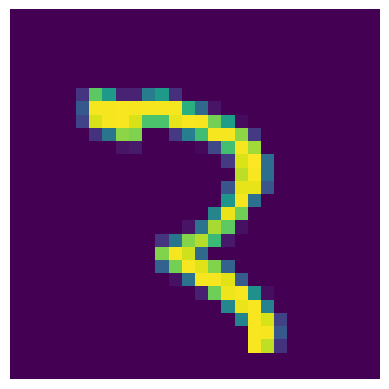

In [ ]:
print("Displaying a sample image from the dataset:")
show_me(X_train[500])

Displaying mean image for Class 7:


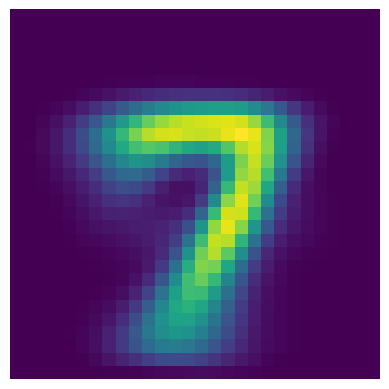

In [ ]:
print("Displaying mean image for Class 7:")
show_me_all_mean(X_train, y_train, 7)

Displaying mean image for Class 1:


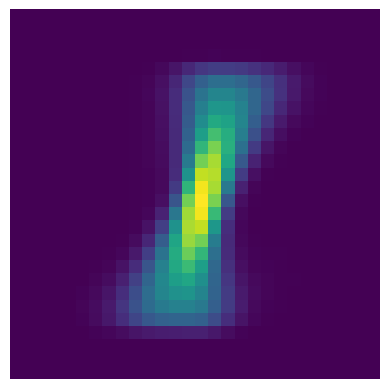

In [ ]:
print("Displaying mean image for Class 1:")
show_me_all_mean(X_train, y_train, 1)

## Identify the top 5 values

In [ ]:
# Calculate pixel intensity variance for each image
variances = X_test.var(axis=1)

low_variance_indices = np.argsort(variances)[:5]

worst_index = np.argmin(variances)

## Display "badly written" digits(5)

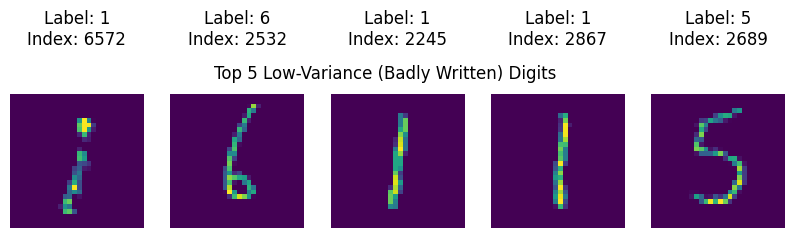

In [ ]:
plt.figure(figsize=(10, 2))
for i, idx in enumerate(low_variance_indices):
    img = X_test[idx].reshape(28, 28)
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Label: {y_test[idx]}\nIndex: {idx}\n\n ")
plt.suptitle("Top 5 Low-Variance (Badly Written) Digits")
plt.show()

## Display the "worst" written digit

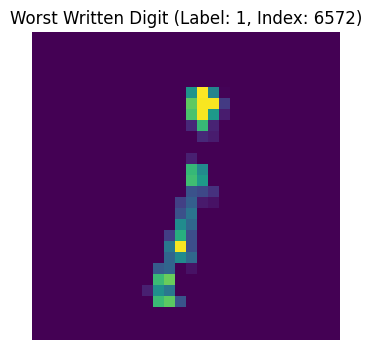

In [ ]:
plt.figure(figsize=(4, 4))
plt.imshow(X_test[worst_index].reshape(28, 28))
plt.axis('off')
plt.title(f"Worst Written Digit (Label: {y_test[worst_index]}, Index: {worst_index})")
plt.show()

# Naive Bayes Classifier

In [ ]:
class GaussNB:
    def fit(self, X, y, epsilon=1e-3):
        self.likelihoods = {}
        self.priors = {}
        self.K = set(y.astype(int))

        for k in self.K:
            X_k = X[y == k]
            self.likelihoods[k] = {"mean": X_k.mean(axis=0), "cov": X_k.var(axis=0) + epsilon}
            self.priors[k] = len(X_k) / len(X)

    def predict(self, X):
        N, D = X.shape
        P_hat = np.zeros((N, len(self.K)))

        for k, l in self.likelihoods.items():
            P_hat[:, k] = mvn.logpdf(X, l["mean"], l["cov"]) + np.log(self.priors[k])

        return P_hat.argmax(axis=1)

In [ ]:
gnb = GaussNB()
gnb.fit(X_train, y_train)
y_hat_tr = gnb.predict(X_train)
print("Naive Bayes Accuracy:", accuracy(y_train, y_hat_tr))

Naive Bayes Accuracy: 0.7682333333333333


## Instantiate and test each classifier on MNIST

In [ ]:
gnb = GaussNB()
gnb.fit(X_train, y_train)
y_hat_nb = gnb.predict(X_test)
print("Naive Bayes Accuracy:", accuracy(y_test, y_hat_nb))

Naive Bayes Accuracy: 0.7746


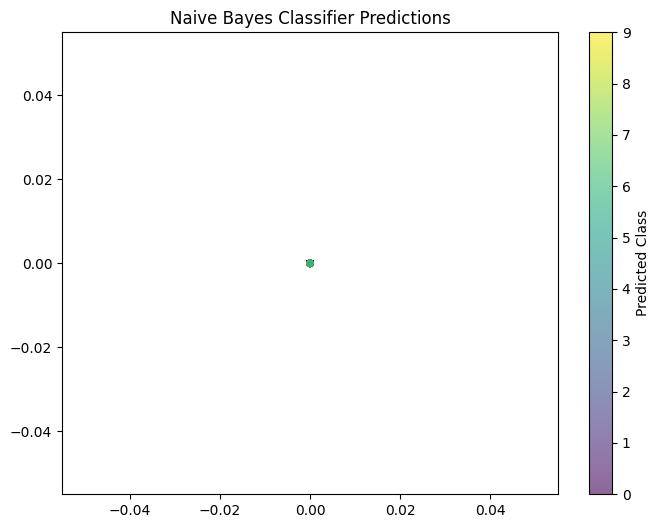

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_hat_nb, alpha=0.6, s=20)
plt.colorbar(scatter, label='Predicted Class')
plt.title("Naive Bayes Classifier Predictions")
plt.show()

# Confusion Matrix

In [ ]:
def compute_confusion_matrix(y_true, y_pred):
    num_classes = len(np.unique(y_true))
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for true, pred in zip(y_true, y_pred):
        confusion_matrix[int(true), int(pred)] += 1

    return confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    conf_matrix = compute_confusion_matrix(y_true, y_pred)


    plt.figure(figsize=(8, 6))
    cax = plt.matshow(conf_matrix, cmap='Blues', fignum=1)
    plt.colorbar(cax)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    num_classes = conf_matrix.shape[0]
    plt.xticks(np.arange(num_classes))
    plt.yticks(np.arange(num_classes))


    for (i, j), value in np.ndenumerate(conf_matrix):
        plt.text(j, i, value, ha="center", va="center", color="black")

    plt.show()

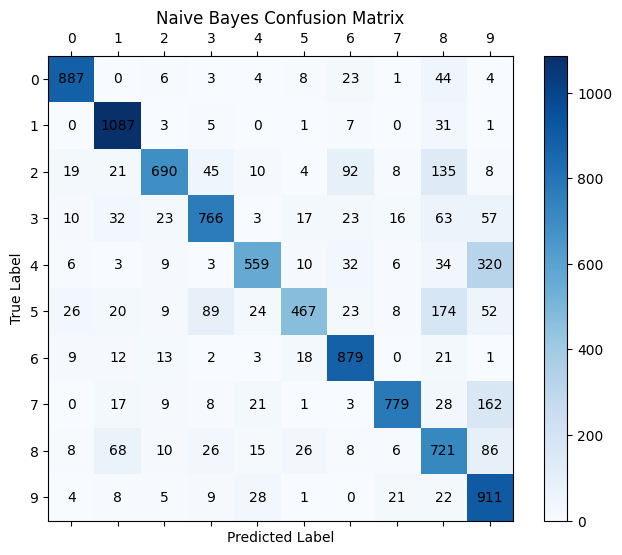

In [ ]:
plot_confusion_matrix(y_test, y_hat_nb, "Naive Bayes")

# Non-Naive Bayesian Classifier

In [ ]:
class GaussBayes:
    def fit(self, X, y, epsilon=1e-3):
        self.likelihoods = {}
        self.priors = {}
        self.K = set(y.astype(int))

        for k in self.K:
            X_k = X[y == k]
            N_k, D = X_k.shape
            mu_k = X_k.mean(axis=0)
            self.likelihoods[k] = {"mean": mu_k, "cov": (1 / (N_k - 1)) * np.matmul((X_k - mu_k).T, X_k - mu_k) + epsilon * np.identity(D)}
            self.priors[k] = len(X_k) / len(X)

    def predict(self, X):
        N, D = X.shape
        P_hat = np.zeros((N, len(self.K)))

        for k, l in self.likelihoods.items():
            P_hat[:, k] = mvn.logpdf(X, l["mean"], l["cov"]) + np.log(self.priors[k])

        return P_hat.argmax(axis=1)

In [ ]:
gauss_b = GaussBayes()
gauss_b.fit(X_train, y_train)
y_hat_train = gauss_b.predict(X_train)
print("Non-Naive Bayesian Accuracy:", accuracy(y_train, y_hat_train))

Non-Naive Bayesian Accuracy: 0.9306333333333333


In [ ]:
gauss_b = GaussBayes()
gauss_b.fit(X_train, y_train)
y_hat_bayes = gauss_b.predict(X_test)
print("Non-Naive Bayesian Accuracy:", accuracy(y_test, y_hat_bayes))

Non-Naive Bayesian Accuracy: 0.9108


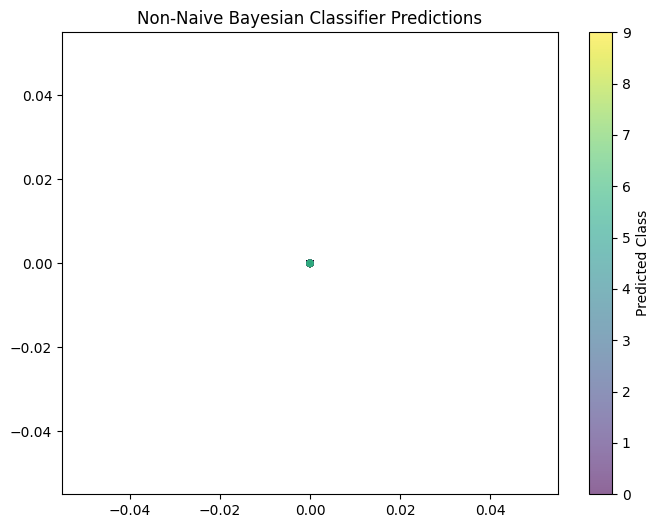

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_hat_bayes, alpha=0.6, s=20)
plt.colorbar(scatter, label='Predicted Class')
plt.title("Non-Naive Bayesian Classifier Predictions")
plt.show()

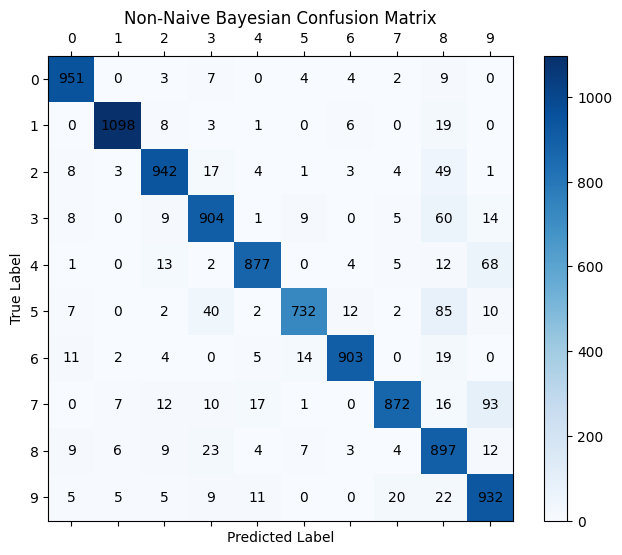

In [ ]:
plot_confusion_matrix(y_test, y_hat_bayes, "Non-Naive Bayesian")

# K-Nearest Neighbors Classifier

In [ ]:
class KNNClassifier:
    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X, K=3, epsilon=1e-3):
        N = len(X)
        y_hat = np.zeros(N)

        for i in range(N):
            dist2 = np.sum((self.X - X[i]) ** 2, axis=1)
            idxt = np.argsort(dist2)[:K]
            gamma_k = 1 / (np.sqrt(dist2[idxt] + epsilon))
            y_hat[i] = np.bincount(self.y[idxt].astype(int), weights=gamma_k).argmax()

        return y_hat

In [ ]:
knn = KNNClassifier()
knn.fit(X_train, y_train)
y_knn_train = knn.predict(X_train, K=5)
print("KNN Accuracy:", accuracy(y_train, y_knn_train))

KNN Accuracy: 1.0


In [ ]:
knn = KNNClassifier()
knn.fit(X_train, y_train)
y_hat_knn = knn.predict(X_test, K=5)
print("KNN Accuracy:", accuracy(y_test, y_hat_knn))

KNN Accuracy: 0.9691


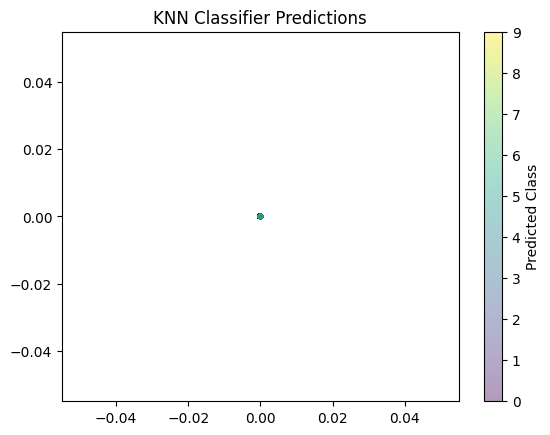

In [ ]:
plt.figure()
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_hat_knn, alpha=0.4, s=10)
plt.colorbar(scatter, label='Predicted Class')
plt.title("KNN Classifier Predictions")
plt.show()

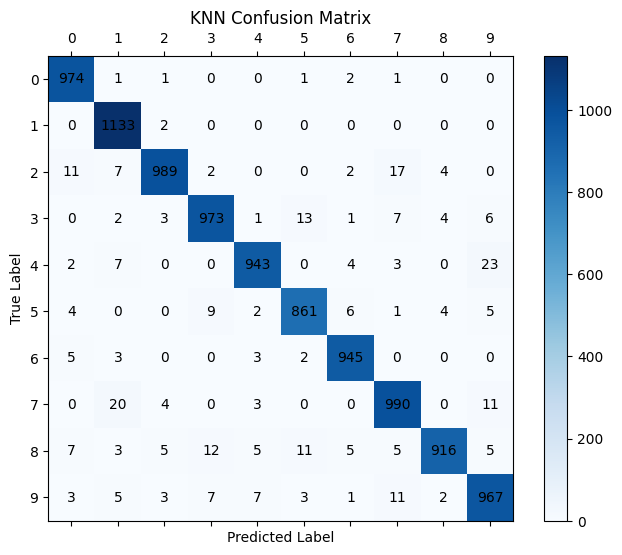

In [ ]:
plot_confusion_matrix(y_test, y_hat_knn, "KNN")